<a href="https://colab.research.google.com/github/AntonioDeFA/etl_pyspark/blob/develop/Dados_IBGE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark findspark

In [2]:
import findspark
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql import SparkSession, Row
from pyspark.sql.window import Window

In [3]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode('ASCII')

In [85]:
findspark.init()


udf_remove_accents = udf(remove_accents,
                         StringType())

spark = SparkSession.builder \
    .appName("Dados IBGE") \
    .getOrCreate()

spark.udf.register("sql_remove_accents",
                   remove_accents,
                   StringType())

input_path_ibge = "/content/cities-brazil-ibge.csv"
data_ibge = spark.read.csv(input_path_ibge,
                           header=True,
                           inferSchema=True,
                           sep=",",
                           encoding="UTF-8")

input_path_covid = "/content/cases-brazil-cities-time_2022.csv"
data_covid = spark.read.csv(input_path_covid,
                            header=True,
                            inferSchema=True,
                            sep=",",
                            encoding="UTF-8")

In [86]:
data_ibge.createOrReplaceTempView("tb_ibge")
data_covid.createOrReplaceTempView("tb_covid")

spark.sql("SELECT epi_week AS epi_mes, \
                  date AS data,  \
                  state AS estado, \
                  upper(sql_remove_accents(city)) AS cidade, \
                  ibgeID,  \
                  newDeaths AS novas_mortes,  \
                  deaths AS mortes,  \
                  newCases AS novos_casos, \
                  totalCases AS total_casos, \
                  deaths_per_100k_inhabitants AS morte_por_100k_habitantes, \
                  totalCases_per_100k_inhabitants AS total_morte_por_100k_habitantes, \
                  deaths_by_totalCases AS mortes_por_total_de_casos \
                  FROM tb_covid")\
                  .createOrReplaceTempView("tb_covid_traduzido")

spark.sql("SELECT epi_mes, \
                  data, \
                  estado, \
                  upper(sql_remove_accents(cidade)) AS cidade, \
                  ibgeID, \
                  novas_mortes, \
                  mortes, \
                  novos_casos, \
                  total_casos, \
                  morte_por_100k_habitantes, \
                  total_morte_por_100k_habitantes, \
                  mortes_por_total_de_casos \
                  FROM tb_covid_traduzido")\
                  .createOrReplaceTempView("tb_covid_sem_acento")

spark.sql("SELECT epi_mes, \
                  data, \
                  estado, \
                  SUBSTR(cidade, 1, INSTR(cidade, '/') - 1) AS cidade, \
                  ibgeID, \
                  novas_mortes, \
                  mortes, \
                  novos_casos, \
                  total_casos, \
                  morte_por_100k_habitantes, \
                  total_morte_por_100k_habitantes, \
                  mortes_por_total_de_casos \
                  FROM tb_covid_sem_acento")\
                  .createOrReplaceTempView("tb_covid_sem_estado")



tb_ibge_covid_merged = spark.sql("SELECT * FROM tb_covid_sem_estado \
                                JOIN tb_ibge ON LocalCidade = cidade")

tb_ibge_covid_merged.createOrReplaceTempView("tb_data_atualizada")

In [87]:
window_spec = Window.partitionBy("cidade").orderBy(desc("data"))

df_ordenado_data_recente = tb_ibge_covid_merged.withColumn("row",
                                                           row_number().
                                                           over(window_spec))
df_filtrado_data_recentes = df_ordenado_data_recente.filter(col("row") == 1)\
                                                            .drop("row")

df_filtrado_PB = df_filtrado_data_recentes.filter(col("estado") == "PB")

In [88]:
pd_filtrado_mortes_PB = df_filtrado_PB.orderBy(desc('mortes')).toPandas()

In [89]:
pd_filtrado_quantidade_pessoas_PB = df_filtrado_PB.orderBy(desc('PopEstimada_2018')).limit(10).toPandas()

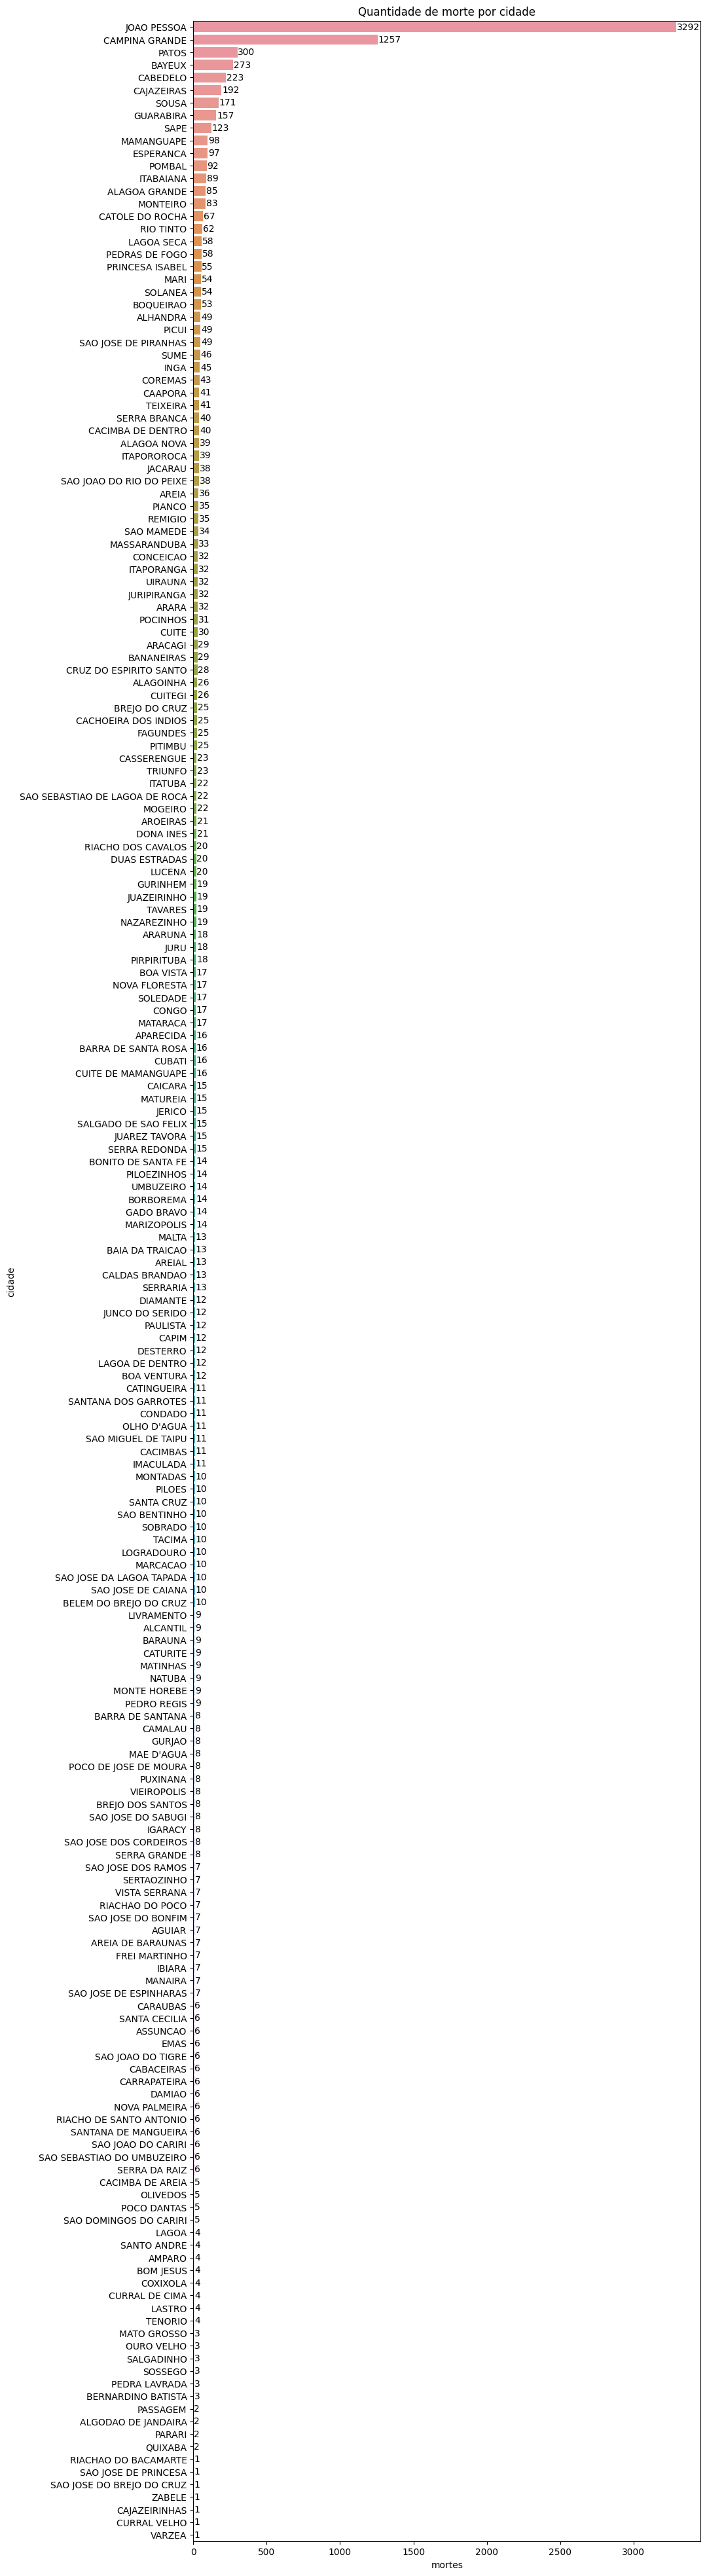

In [90]:
plt.figure(figsize=(10, 50))
plot = sns.barplot(x="mortes", y="cidade", data=pd_filtrado_mortes_PB)
plt.title('Quantidade de morte por cidade')

for p in plot.patches:
    width = p.get_width()
    plt.text(width + 3,
             p.get_y() + p.get_height()/2,
             int(width),
             ha="left", va="center")

<Figure size 5000x700 with 0 Axes>

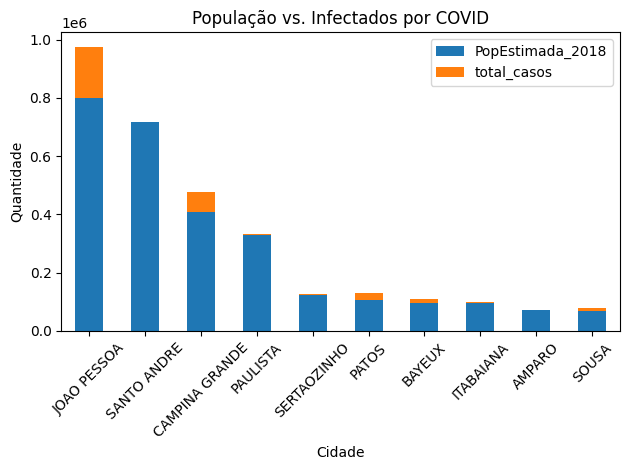

In [91]:
plt.figure(figsize=(50, 7))

pd = pd_filtrado_quantidade_pessoas_PB.plot(x='cidade', y=['PopEstimada_2018', 'total_casos'], kind='bar',stacked=True)

# for p in pd.patches:
#     width, height = p.get_width(), p.get_height()
#     x, y = p.get_xy()
#     pd.text(x+width/2,
#             y+height/2,
#             int(height),
#             horizontalalignment='center',
#             verticalalignment='center')

plt.title('População vs. Infectados por COVID')
plt.ylabel('Quantidade')
plt.xlabel('Cidade')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


<Figure size 5000x700 with 0 Axes>

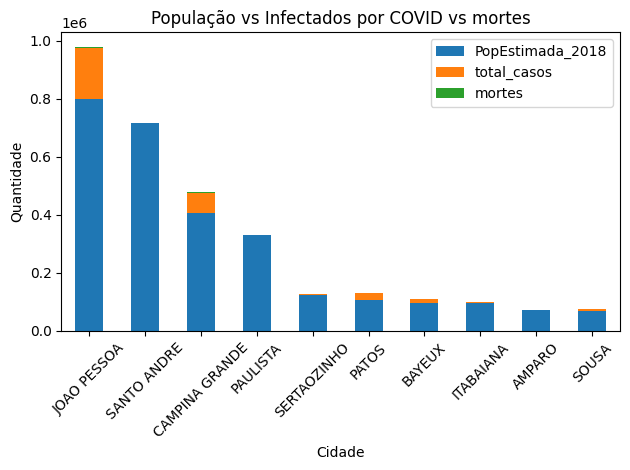

In [92]:
plt.figure(figsize=(50, 7))

pd = pd_filtrado_quantidade_pessoas_PB.plot(x='cidade', y=['PopEstimada_2018', 'total_casos', 'mortes'], kind='bar',stacked=True)

plt.title('População vs Infectados por COVID vs mortes')
plt.ylabel('Quantidade')
plt.xlabel('Cidade')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [93]:
output_path = "relatorio-final.csv"
df_filtrado_PB.write.csv(output_path, header=True)

spark.stop()